<a href="https://colab.research.google.com/github/PastaAddict/Data-mining/blob/main/%CE%95%CE%BE%CE%BF%CF%81%CF%85%CE%BE%CE%B7_%CE%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Transformers Library

In [1]:
!pip install transformers

     |████████████████████████████████| 2.5MB 7.9MB/s 
     |████████████████████████████████| 901kB 47.2MB/s 
     |████████████████████████████████| 3.3MB 46.3MB/s 


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import transformers
from transformers import AutoModel, BertTokenizerFast, AdamW


import matplotlib.pyplot as plt
import seaborn as sns


# specify GPU
device = torch.device("cuda")

In [20]:
try:
  print(torch.cuda.get_device_name(0)) #Hope we get Tesla T4 instead of K80
except:
  device = torch.device("cpu")

Tesla T4


# Load Data

In [4]:
df = pd.read_csv("spam_or_not_spam.csv") #use pandas to read dataset
df.head()

,email,label
0,mike bostock said received from trackingNUMBE...,0
1,no i was just a little confused because i m r...,0
2,this is just an semi educated guess if i m wro...,0
3,jm URL justin mason writes except for NUMBER t...,0
4,i just picked up razor sdk NUMBER NUMBER and N...,0


In [5]:
df['email'][1410]

'dear opportunities seekers i thought you just might be interested in the followings we are currently hiring work home typist clerk secretary supervisor trainer marketer manager we pay weekly NUMBER usd potential no experience ok must know typing no sex age limit part full time anywhere in the world apply now email responsevivek URL and put i am interested in subject line for details no spam give it a chance our business links offshore banking high interests account NUMBER per year after year why just settle for NUMBER since NUMBER more info responsevivek URL take advantage of our malaysia low URL cellular phones cheap brand name motorola siemen etc from NUMBER usd brand new guaranteed world lowest good quality all models details responsevivek URL we also buy sell second hand cell phones quality guaranteed guaranteed world lowest phone rates try use it yourself for free or be an agent for the top ten and get your own free web pages and make big all for free please contact your own perf

In [6]:
df['num_words'] = df['email'].str.split().str.len() #add 2 new columns specifying mail lengths
df['length'] = df['email'].str.len()

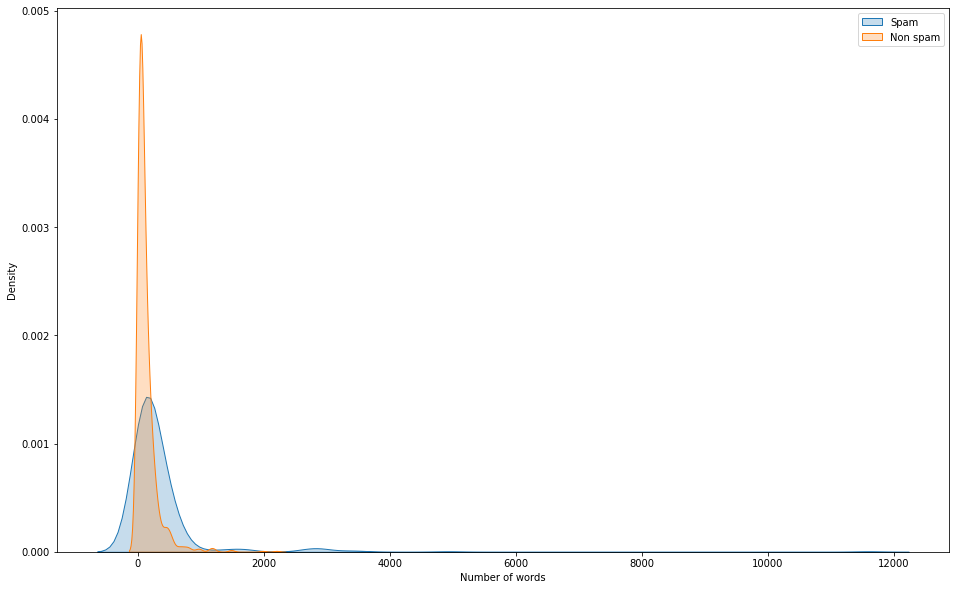

In [7]:
f,ax = plt.subplots(figsize=(16,10))
sns.kdeplot(df.loc[df.label == 1, "num_words"], shade=True, label="Spam")
sns.kdeplot(df.loc[df.label == 0, "num_words"], shade=True, label="Non spam")
ax.set(xlabel = "Number of words", ylabel = "Density")
plt.legend()
plt.show()

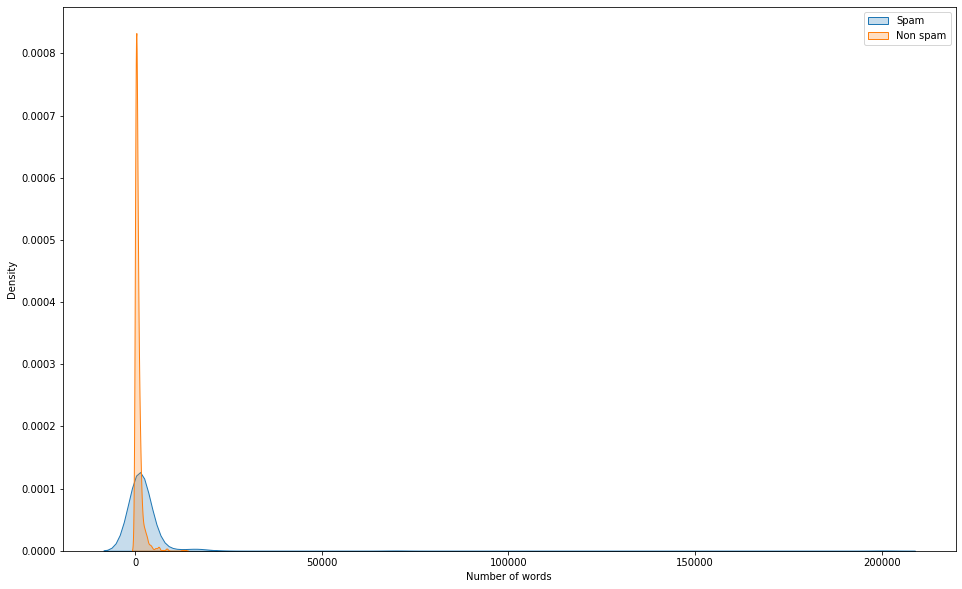

In [8]:
f,ax = plt.subplots(figsize=(16,10))
sns.kdeplot(df.loc[df.label == 1, "length"], shade=True, label="Spam")
sns.kdeplot(df.loc[df.label == 0, "length"], shade=True, label="Non spam")
ax.set(xlabel = "Number of words", ylabel = "Density")
plt.legend()
plt.show()

In [9]:
df = df[['email','label']].dropna() # drop Nan
df['email'] = df['email'].apply(lambda x: ' '.join(x.split()[:512])) # clip all mails to 512, since the model we define has input size 512

In [10]:
print(df.shape) # only 1 Nan
df['label'].value_counts(normalize = True) # check class distribution

(1499, 2)


0    0.667111
1    0.332889
Name: label, dtype: float64

In [11]:
#split data in train set and test set
train_text, _text, train_labels, _labels = train_test_split(df['email'], df['label'], 
                                                                    random_state=69, 
                                                                    test_size=0.4, 
                                                                    stratify=df['label'])

# split test set (_text) to train set and validation set, final relative sizes : train:0.6, test:0.2, val:0.2
val_text, test_text, val_labels, test_labels = train_test_split(_text, _labels, 
                                                                random_state=69, 
                                                                test_size=0.5, 
                                                                stratify=_labels)

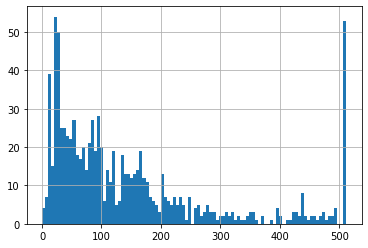

In [12]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 100)

# Import pretrained BERT

In [13]:
# import BERT-base pretrained model and tokenizer
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenize data and convert to tensors

In [14]:
def tokenize(data):
  data = data.tolist() # convert to list of strings
  max_seq_len = len(max(data,key=len).split()) # fing longest string

  data_token =tokenizer.batch_encode_plus(
    data,
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False)
  
  return data_token

In [15]:
tokens_test = tokenize(test_text)
tokens_val = tokenize(val_text)
tokens_train = tokenize(train_text)

In [16]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 64

train_data = TensorDataset(train_seq, train_mask, train_y) #gather train data
train_sampler = RandomSampler(train_data) #random samplig for training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) #dataloader for random batch generation

# same for validation data
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Model

In [18]:
class BERT(nn.Module):

    def __init__(self, bert):
      
      super(BERT, self).__init__()

      self.bert = bert #pretrained BERT 
      
      #BERT output is the fed through the FC classifying portion of the model
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,2)
      self.softmax = nn.LogSoftmax(dim=1) #binary classification

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      x = self.bert(sent_id, attention_mask=mask)[1]
      
      x = self.fc1(x)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)

      return x

In [21]:
# freeze all the parameters, only train the classifier portion of the model, fine tuning
for param in bert.parameters():
    param.requires_grad = False
    
# pass the pre-trained BERT to our model
model = BERT(bert).to(device)

In [ ]:
model

BERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       

# Training and validation steps functions

In [22]:
def train(): # training step function
  
  model.train()

  total_loss, total_accuracy = 0, 0
  total_preds=[] # stores model predictions
  
  for step,batch in enumerate(train_dataloader): # for each batch in the dataloader
    
    if step % 50 == 0 and not step == 0: # progress
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    batch = [r.to(device) for r in batch] # push the batch to gpu
 
    sent_id, mask, labels = batch
    model.zero_grad() # reset gradients      

    preds = model(sent_id, mask) # feed batch through model
    loss = cross_entropy(preds, labels) # calculate loss
    total_loss = total_loss + loss.item() # add losses for each batch together

    loss.backward() # backward pass to calculate loss gradients wrt only to model classifier parameters
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip the the gradients to 1.0 for exploding gradient problem
    optimizer.step() # update parameters
    preds=preds.detach().cpu().numpy() # back to cpu

    total_preds.append(preds)

  avg_loss = total_loss / len(train_dataloader) # compute the training loss of the epoch
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds #returns the loss and predictions

In [23]:
def evaluate(): # function for evaluating the model
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  total_preds = []

  for step,batch in enumerate(val_dataloader): #for each batch in the validation set
  
    batch = [t.to(device) for t in batch] # push it to gpu
    sent_id, mask, labels = batch #batch data

    with torch.no_grad(): # deactivate autograd

      preds = model(sent_id, mask) # feed val data to model and get predictions
      loss = cross_entropy(preds,labels) # calculate validation loss

      total_loss = total_loss + loss.item() # sum losses of each batch
      preds = preds.detach().cpu().numpy() # back to cpu

      total_preds.append(preds)

  avg_loss = total_loss / len(val_dataloader) #validation loss

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [24]:
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels) # compute the class weights
optimizer = AdamW(model.parameters(), lr = 1e-4) # optimizer similar to Adam

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 200


 Epoch 1 / 200

Evaluating...

Training Loss: 0.695
Validation Loss: 0.667

 Epoch 2 / 200

Evaluating...

Training Loss: 0.665
Validation Loss: 0.635

 Epoch 3 / 200

Evaluating...

Training Loss: 0.631
Validation Loss: 0.617

 Epoch 4 / 200

Evaluating...

Training Loss: 0.615
Validation Loss: 0.597

 Epoch 5 / 200

Evaluating...

Training Loss: 0.583
Validation Loss: 0.575

 Epoch 6 / 200

Evaluating...

Training Loss: 0.610
Validation Loss: 0.578

 Epoch 7 / 200

Evaluating...

Training Loss: 0.584
Validation Loss: 0.575

 Epoch 8 / 200

Evaluating...

Training Loss: 0.565
Validation Loss: 0.531

 Epoch 9 / 200

Evaluating...

Training Loss: 0.534
Validation Loss: 0.521

 Epoch 10 / 200

Evaluating...

Training Loss: 0.545
Validation Loss: 0.491

 Epoch 11 / 200

Evaluating...

Training Loss: 0.499
Validation Loss: 0.496

 Epoch 12 / 200

Evaluating...

Training Loss: 0.521
Validation Loss: 0.461

 Epoch 13 / 200

Evaluating...

Training Loss: 0.485
Validation Loss: 0.450

 Epoch 

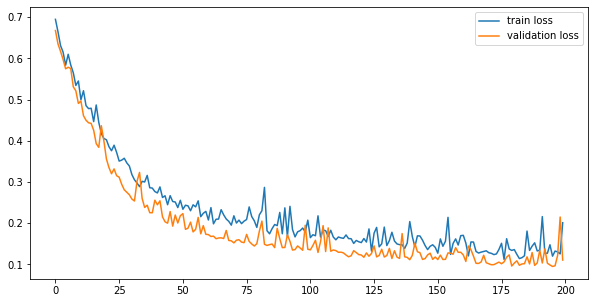

In [25]:
best_valid_loss = float('inf')

train_losses=[] # store losses
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs)) #show progress
    
    train_loss, _ = train() # train step
    valid_loss, _ = evaluate() # evaluation step
    
    if valid_loss < best_valid_loss: #save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

fig = plt.figure(figsize=(10,5))
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='validation loss')
plt.legend()

# Load Saved Model

In [26]:
#load best model
path = 'best_model.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Classification Results

In [33]:
with torch.no_grad(): #test on test data
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

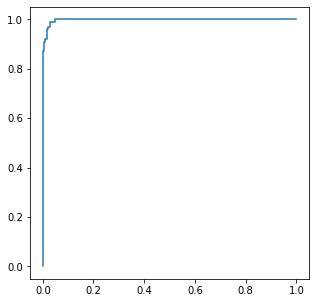

In [38]:
confidence = np.exp(preds[:,1]) #probability of being class 1
fpr, tpr, thresholds = roc_curve(test_y, confidence, pos_label=1, drop_intermediate=False) #roc curve

fig = plt.figure(figsize=(5,5)) #plot roc curve
plt.plot(fpr,tpr)

In [39]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       200
           1       0.94      0.98      0.96       100

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



In [40]:
print(f"""Accuray: {round(accuracy_score(test_y, preds), 5) * 100}%
ROC-AUC: {round(roc_auc_score(test_y, preds), 5) * 100}%""")

Accuray: 97.333%
ROC-AUC: 97.5%


In [41]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,194,6
1,2,98


In [42]:
mail = tokenize(pd.Series('Click here for 1000000 dollars'))
mail_seq = torch.tensor(mail['input_ids'])
mail_mask = torch.tensor(mail['attention_mask'])

prediction = model(mail_seq.to(device), mail_mask.to(device)).detach().cpu().numpy()
print('spam' if np.argmax(prediction) else 'not spam')

spam
